DB connection Success!
DB connection Success!
                   date    sunlight  temperature      pv
0   2023-08-27 16:00:00   78.208333    36.983333   13.03
1   2023-08-27 17:00:00   35.608333    34.958333   16.32
2   2023-08-27 18:00:00    4.558333    32.725000    0.07
3   2023-08-27 19:00:00    0.000000    30.405172    0.00
4   2023-08-27 20:00:00    0.000000    30.000000    0.00
..                  ...         ...          ...     ...
294 2023-09-12 10:00:00  201.275000    31.800000  145.10
295 2023-09-12 11:00:00  261.841667    34.391667  181.10
296 2023-09-12 12:00:00  180.158333    35.625000  127.80
297 2023-09-12 13:00:00  177.508333    36.066667  126.10
298 2023-09-12 14:00:00  164.375000    35.604167   90.50

[299 rows x 4 columns]
Train Score: 13.35 RMSE
Test Score: 21.85 RMSE


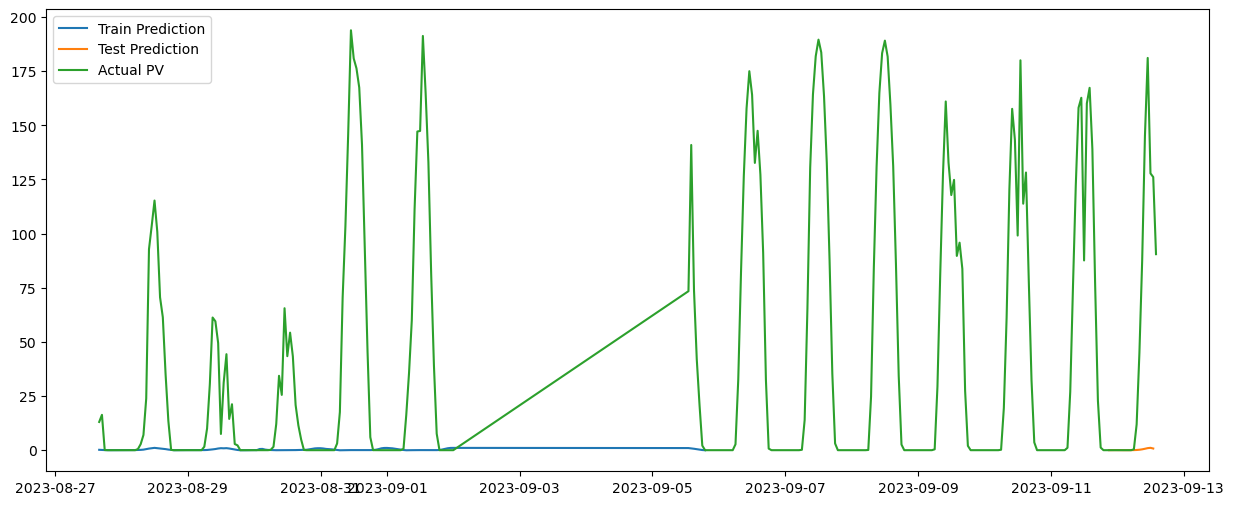

In [21]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import db_fn

# 시계열 데이터를 supervised learning 데이터로 변환
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :-1]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

# 1. 데이터 전처리
data = db_fn.get_pv_dataset()
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 훈련용 및 테스트용 데이터 분리
train_size = int(len(scaled_data) * 0.7)
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

look_back = 24*3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# LSTM 입력 형태에 맞게 데이터 reshape
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

# 2. LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 3. 모델 훈련
model.fit(trainX, trainY, epochs=50, batch_size=12, verbose=0)

# 4. 예측 및 평가
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 원래 스케일로 변환
trainPredict_combined = np.column_stack((train[look_back:-1, :-1], trainPredict))
trainPredict_inversed = scaler.inverse_transform(trainPredict_combined)
trainY_actual_combined = np.column_stack((train[look_back:-1, :-1], trainY))
trainY_actual_inversed = scaler.inverse_transform(trainY_actual_combined)

testPredict_combined = np.column_stack((test[look_back:-1, :-1], testPredict))
testPredict_inversed = scaler.inverse_transform(testPredict_combined)
testY_actual_combined = np.column_stack((test[look_back:-1, :-1], testY))
testY_actual_inversed = scaler.inverse_transform(testY_actual_combined)

# RMSE 계산
trainScore = np.sqrt(mean_squared_error(trainY_actual_inversed[:, -1], trainPredict_inversed[:, -1]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY_actual_inversed[:, -1], testPredict_inversed[:, -1]))
print(f'Test Score: {testScore:.2f} RMSE')


# 예측 결과 그래프로 표현
plt.figure(figsize=(15,6))
plt.plot(data.index[:len(trainPredict)], trainPredict[:, -1], label="Train Prediction")
plt.plot(data.index[len(trainPredict)+look_back*2+1:len(data)-1], testPredict[:, -1], label="Test Prediction")
plt.plot(data.index, data['pv'], label="Actual PV")
plt.legend()
plt.show()


In [15]:
import db_fn

db_fn.get_pv_dataset()

DB connection Success!
DB connection Success!
                   date    sunlight  temperature      pv
0   2023-08-27 16:00:00   78.208333    36.983333   13.03
1   2023-08-27 17:00:00   35.608333    34.958333   16.32
2   2023-08-27 18:00:00    4.558333    32.725000    0.07
3   2023-08-27 19:00:00    0.000000    30.405172    0.00
4   2023-08-27 20:00:00    0.000000    30.000000    0.00
..                  ...         ...          ...     ...
294 2023-09-12 10:00:00  201.275000    31.800000  145.10
295 2023-09-12 11:00:00  261.841667    34.391667  181.10
296 2023-09-12 12:00:00  180.158333    35.625000  127.80
297 2023-09-12 13:00:00  177.508333    36.066667  126.10
298 2023-09-12 14:00:00  122.979592    35.469388   22.00

[299 rows x 4 columns]


,date,sunlight,temperature,pv
0,2023-08-27 16:00:00,78.208333,36.983333,13.03
1,2023-08-27 17:00:00,35.608333,34.958333,16.32
2,2023-08-27 18:00:00,4.558333,32.725000,0.07
3,2023-08-27 19:00:00,0.000000,30.405172,0.00
4,2023-08-27 20:00:00,0.000000,30.000000,0.00
...,...,...,...,...
294,2023-09-12 10:00:00,201.275000,31.800000,145.10
295,2023-09-12 11:00:00,261.841667,34.391667,181.10
296,2023-09-12 12:00:00,180.158333,35.625000,127.80
297,2023-09-12 13:00:00,177.508333,36.066667,126.10


In [ ]:
# ... [이전의 코드 중 데이터 로딩 부분]

# 과거 데이터 로딩
past_data = pd.read_csv('your_data_path.csv')
past_data['date'] = pd.to_datetime(past_data['date'])
past_data = past_data.sort_values('date')

# 미래의 sunlight와 temperature 값을 불러오기
def load_future_weather(target_date):
    future_weather = pd.read_csv('weather.csv')
    future_weather['date'] = pd.to_datetime(future_weather['date'])
    future_weather = future_weather.sort_values('date')
    return future_weather[(future_weather['date'] > past_data['date'].iloc[-1]) & (future_weather['date'] <= target_date)][['sunlight', 'temperature']]

target_date = "2023-09-15 16:00:00"
future_weather_data = load_future_weather(target_date)

# 과거 데이터와 미래 데이터 결합
combined_data = pd.concat([past_data[['sunlight', 'temperature', 'pv']], future_weather_data], axis=0).reset_index(drop=True)
combined_data['pv'] = combined_data['pv'].fillna(0)

In [ ]:
# ... [이전의 코드 중 데이터 전처리 부분]

# LSTM 모델 학습 및 예측
# ... [이전의 LSTM 학습 코드]

# 미래 데이터에 대한 예측
X_future, _ = create_dataset(scaled_data[-len(future_weather_data)-look_back:], look_back)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 2))

# 예측
futurePredict = model.predict(X_future)

# 역정규화
futurePredict = scaler.inverse_transform(np.c_[futurePredict, np.zeros(futurePredict.shape)])

print(f"태양광 발전량 예측 (up to {target_date}):")
for i, predict in enumerate(futurePredict):
    print(f"{future_weather_data.iloc[i]['date'].strftime('%Y-%m-%d %H:%M:%S')}: {predict[0]:.2f}")